In [1]:
import torch
from torch_geometric.data import Data, DataLoader
from cnf import BipartiteData
from loss import LossCompute, push_to_side
import time
import numpy as np
import matplotlib.pyplot as plt

ImportError: cannot import name 'SimpleLossCompute' from 'loss' (/home/cchenli/Documents/transformers.satisfy/src/loss.py)

In [ ]:
# add a folder raw under dataset manually before execute this chunk
from data import SATDataset
ds = SATDataset('../dataset', 'RND3SAT/uf50-218', False)
last_trn, last_val = int(len(ds)), int(len(ds))
train_ds = ds[: last_trn]
valid_ds = ds[last_trn: last_val]
test_ds = ds[last_val:]

In [4]:
test_data = train_ds[1]
edge_index_pos = test_data.edge_index_pos
edge_index_neg = test_data.edge_index_neg
variable_count = max(max(edge_index_pos[1]), max(edge_index_neg[1])) + 1
clause_count = len(edge_index_pos[1])

# Debug for loss.py

In [5]:
def test_loss(iter_num, par_sm, par_sg, var_num, plot=False):
    loss_func = SimpleLossCompute(par_sm, par_sg, debug=True)
    loss_func2 = SimpleLossCompute2(par_sm, par_sg, debug=True)
    sat_rate = np.zeros(iter_num)
    loss_v = np.zeros(iter_num)
    loss2_v = np.zeros(iter_num)
    time1 = np.zeros(iter_num)
    time2 = np.zeros(iter_num)
    for i in range(iter_num):
        x_s = push_to_side(torch.rand(var_num, 1), par_sg)
        start = time.time()
        loss, sm = loss_func(x_s, edge_index_pos, edge_index_neg)
        time1[i] = time.time() - start
        satisfied_percentage = sum(sm > 0.5).numpy() / clause_count
        loss_v[i] = loss

        start = time.time()
        loss2, sm2 = loss_func2(x_s, edge_index_pos, edge_index_neg)
        time2[i] = time.time() - start
        loss2_v[i] = loss2
        if sum(sm > 0.5).numpy() / clause_count != satisfied_percentage:
            raise ValueError("Two loss should return same sm")
        sat_rate[i] = satisfied_percentage
    if plot:
        plt.plot(sat_rate, loss_v, "ro")
        plt.xlabel("Satisfied Clauses / Numer of Clauses")
        plt.ylabel("Loss")
    return sat_rate, loss_v, loss2_v, time1, time2

Time for loss1 and loss2 to compute loss of 5000 FG respectively takes 18.93904685974121s


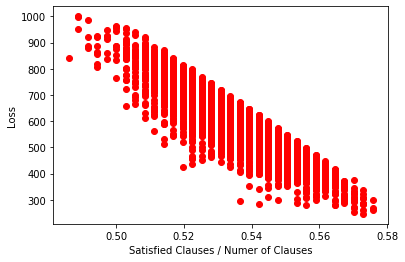

In [6]:
start = time.time()
sat_rate, loss_v, loss2_v, time1, time2 = test_loss(5000, 30, 50, variable_count, plot=True)
span = time.time() - start
print(f"Time for loss1 and loss2 to compute loss of 5000 FG respectively takes {span}s")

In [7]:
ave_time_diff = sum(time1 - time2) / 5000
print(ave_time_diff)
print(min(loss_v))
print(time1[0:10])
print(time2[0:10])

-4.288549423217773e-05
246.32054138183594
[0.099231   0.00023913 0.00020719 0.00031924 0.00021005 0.00027084
 0.00020981 0.00040913 0.00024104 0.00026393]
[0.00036716 0.00026679 0.00026393 0.0002749  0.00026488 0.00028276
 0.00028491 0.00040579 0.00026584 0.00026798]


# Debug for models.py

In [14]:
import models
from args import make_args

In [29]:
class Args():
    def __init__(self):
        self.dataset = 'RND3SAT/uf50-218'
        self.dataset_root = '../dataset'
        self.loss = 'l2'
        self.gpu = False
        self.cuda = '0'
        self.graph_valid_ratio = 0.1
        self.graph_test_ratio = 0.1
        self.feature_transform = False
        self.drop_rate = 0.5
        self.speedip = False
        self.load_model = False
        self.batch_size = 1
        self.num_layers = 2
        self.num_encoder_layers = 2
        self.num_decoder_layers = 2
        self.num_meta_paths = 4
        self.encoder_channels = '1,16,32'
        self.decoder_channels = '32,16,16'
        self.self_att_heads = 8
        self.cross_att_heads = 8
        self.lr = 1e-6
        self.p = 1e-3
        self.a = 1e-3
        self.warmup_steps = 200
        self.opt_train_factor = 4
        self.epoch_num = 201
        self.epoch_log = 50
        self.epoch_save = 50
        self.save_root = 'saved_model'

## sample a test data

In [30]:
args = Args()
test_data = train_ds[1]
edge_index_pos = test_data.edge_index_pos
edge_index_neg = test_data.edge_index_neg
xv = torch.rand(50)
xc = torch.ones(218)
variable_count = max(max(edge_index_pos[1]), max(edge_index_neg[1]))+1
clause_count = max(max(edge_index_pos[0]), max(edge_index_neg[0]))+1
edge_count = len(edge_index_pos[1])

## Initialize a model and to make it run through

In [31]:
model = models.make_model(args)
literal_assignment = model(xv, xc, edge_index_pos, edge_index_neg)
loss_func = loss_func = SimpleLossCompute(par_sm, par_sg, "cuda")
loss_of_this_assignent = loss_func(x_s, edge_index_pos, edge_index_neg)

edge pos: 356; edge neg: 298; m: 218; n: 50


RuntimeError: The size of tensor a (16) must match the size of tensor b (50) at non-singleton dimension 0

# After finish model.py, debug train.py